['Bad' 'Intermediate']
Normalized confusion matrix
Confusion matrix, without normalization


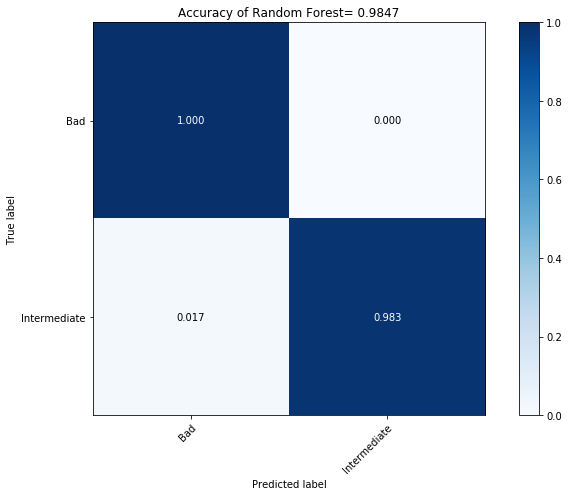

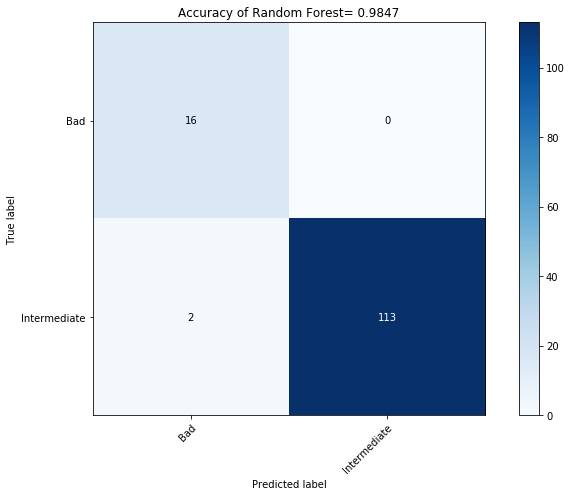

In [27]:
import pandas as pd
%matplotlib inline

import matplotlib.pyplot as plt
pd.options.display.max_rows=10
from datetime import datetime
from statsmodels.tsa.arima_model import ARIMA
import xgboost
import graphviz
import matplotlib.dates as md
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.preprocessing import scale
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
import scipy
from scipy.stats import spearmanr
from pylab import rcParams
import seaborn as sb
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 7
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller, arma_order_select_ic
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
#rcParams['figure.figsize']=5,4
#sb.set_style('whitegrid')

import numpy as np
df = pd.read_table("grenoble_7.k7",sep = ',',header = 0)
class_names=['Bad','Intermediate','Good']
#print(type(df))
#print(df.shape)#Affiche le nombre de ligne et le nombre de colonne de mon fichier
#test=df.head(15)#Affiche les premières lignes du fichier (les ( premières))
#print(df.columns)#Affiche toutes les colonnes du fichier(leur nom)
#print(df.dtypes)#Affiche les noms des colones et leurs types
#print(df.info())#Affiche les informations complémentaires sur chacun des champs (nombre d'occurence, type, ...)
#test=df['mean_rssi'].describe()#Affiche les éléments de la statistique descriptive de la colonne donnée 
#test=df['datetime'].sort_values()#Permet de trier les données sélectionnées
#test=df.iloc[0:10,:]#Affiche les 10 première lignes de mon fichier
#test=df.iloc[0:10,[0,3,4,5]]#Affiche les colonnes 0, 3, 4 ert 5 des 10 premières lignes de mes données
#test=df.loc[df['src']==0,:]#Affiche uniquement les lignes où le src=0
#test=df.loc[(df['src']==0)&(df['channel']==11),:]//Affiche uniquement les lignes dont src=0 et channel=11
#colonne=['datetime', 'src', 'dst', 'channel', 'mean_rssi', 'pdr']
#test=df.loc[(df['src']==0)&(df['channel']==11),colonne]#Affiche les ligne dont src=0 et channel=11. N'affiche que les colonnes mentionnées dans le tableau "colonne"
#df.hist(column='mean_rssi')#Trace l'histogramme de la colonne "mean_rssi"
#df['mean_rssi'].plot.kde()#Permet de tracer la courbe des densité sur mean_rssi
#df.hist(column='mean_rssi',by='channel')#Trace l'histogramme de lean_rssi en fonction de channel
#test = pd.date_range(start='1/1/2018', end='1/12/2018', freq='D')

#df['datetime'] = pd.to_datetime(df['datetime'],format='%Y-%m-%d %H:%M:%S')#Convertie les données de la colone 'datetime' en type date
#df=df.set_index('datetime')
#df.hist(column='mean_rssi',by='datetime')
target_count=df.channel.value_counts()

labels = df.columns[5]

X = df[labels]
y = df['pdr']

def val_prediction_pdr(df):
    ret=list()
    for i in range(len(df)):
        if df['pdr'][i] < 0.02:
            ret.append(0.5)
        elif df['pdr'][i] >= 0.02 and df['pdr'][i] < 0.25:
            ret.append(df['pdr'][i])
        elif df['pdr'][i] >= 0.25 and df['pdr'][i] < 0.3:
            ret.append(0.9)
        elif df['pdr'][i] >= 0.3 and df['pdr'][i] <= 0.35:
            ret.append(0.1)
        elif df['pdr'][i] > 0.35 and df['pdr'][i] <= 0.73:
            ret.append(df['pdr'][i])
        elif df['pdr'][i] >= 0.73 and df['pdr'][i] <= 0.75:
            ret.append(0.9)
        elif df['pdr'][i] > 0.75 and df['pdr'][i] <= 0.8:
            ret.append(0.1)
        elif df['pdr'][i] > 0.8 and df['pdr'][i] < 0.85:
            ret.append(0.5)
        else:
            ret.append(df['pdr'][i])
    #print(ret)
    return ret

 

def logistic_regression_init(df):
    ros = RandomOverSampler(random_state=0)
    rus = RandomUnderSampler(random_state=0)
    y_true=list()
    y_pred=list()
    target=list()
    val_pred=val_prediction_pdr(df)
    for i in range(len(df)):
        if df['pdr'][i] < 0.3:
            target.append(0)
        elif df['pdr'][i] > 0.75:
            target.append(2)
        else:
            target.append(1)
        
        if val_pred[i] < 0.3:
            y_pred.append(0)
        elif val_pred[i] > 0.75:
            y_pred.append(2)
        else:
            y_pred.append(1)
    df['target']=target
    df['pred']=y_pred
    y=df['pred']
    mydata=df.ix[:,(5,7)].values
    pdr=df['pdr']
    target=df['target']
    spearmanr_coefficient,p_value=spearmanr(pdr,target)
    #print(' Spearmanr Rank Correlation %0.3f' %(spearmanr_coefficient))
    X=scale(mydata)
    LogReg=LogisticRegression()
    LogReg.fit(X,y)
    print (LogReg.score(X,y))
    y_pred=LogReg.predict(X)
    from sklearn.metrics import classification_report
    print(classification_report(y,y_pred))
    

def arma(df, classes, normalize=False, title=None,cmap=plt.cm.Blues):
    ros = RandomOverSampler(random_state=0)
    rus = RandomUnderSampler(random_state=0)
    y_true=list()
    y_pred=list()
    target=list()
    val_pred=val_prediction_pdr(df)
    for i in range(len(df)):
        if df['pdr'][i] < 0.3:
            target.append(0)
        elif df['pdr'][i] > 0.75:
            target.append(2)
        else:
            target.append(1)
        
        if val_pred[i] < 0.3:
            y_pred.append(0)
        elif val_pred[i] > 0.75:
            y_pred.append(2)
        else:
            y_pred.append(1)
    df['target']=target
    df['pred']=y_pred
    mydata=df.ix[:,(5,7)].values#Column 5 corresponds to the value of PDR and column 7 to the value representing that valu in class(BadnGood and Intermediate)
    X=scale(mydata)
    y=df['pred']
    X_resampled, y_resampled = ros.fit_resample(X, y)
    
    my_y=df['target']
    arma = ARMA(my_y,order=[4,4])
    
    res=arma.fit(trend="nc")
    params=res.params
    residuals = res.resid
    p = res.k_ar
    q = res.k_ma
    k_exog = res.k_exog
    k_trend = res.k_trend
    steps = 1
    
    y_pred=arma.predict(params)
    
    print('y_pred:  ==>', y_pred)
    
    print ('Accuracy ARMA: ',arma.score(y_pred))
    #print (arma.predict(y))
    #y_pred=arma.predict(X)
    from sklearn.metrics import classification_report
    
def plot_ar4(df):
    df=df.set_index('datetime')
    ts=df['pdr']
    ts_log = np.log(ts)
    ts_log_diff = ts_log - ts_log.shift()
    model=ARIMA(ts_log,order=(2,1,0))
    results_AR=model.fit(disp=-1)
    plt.plot(ts_log_diff)
    plt.plot(results_AR.fittedvalues,color='red')
    plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))
    plt.savefig("ARMA\AR.png", format='png', bbox_inches='tight', pad_inches=0)
    plt.clf()
        
def plot_ma(df):
    df=df.set_index('datetime')
    ts=df['pdr']
    ts_log = np.log(ts)
    ts_log_diff = ts_log - ts_log.shift()
    model=ARIMA(ts_log,order=(0,1,2))
    results_MA=model.fit(disp=-1)
    plt.plot(ts_log_diff)
    plt.plot(results_MA.fittedvalues,color='red')
    plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))
    plt.savefig("ARMA\MA.png", format='png', bbox_inches='tight', pad_inches=0)
    plt.clf()
    
def plot_arima(df):
    df=df.set_index('datetime')
    ts=df['pdr']
    ts_log = np.log(ts)
    ts_log_diff = ts_log - ts_log.shift()
    model=ARIMA(ts_log,order=(1,0,1))
    results_MA=model.fit(disp=-1)
    plt.plot(ts_log_diff)
    plt.plot(results_MA.fittedvalues,color='red')
    plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))
    plt.savefig("C:\\Users\WSN-LINK\\Documents\\TEST\\SOCALE\\CHOOSE\\PDR\\ARIMA.png", format='png', bbox_inches='tight', pad_inches=0)
    plt.clf()

    
def plot_arma(df):
    df=df.set_index('datetime')
    df.index=pd.to_datetime(df.index)
    
    ts=df['pdr']
    results = adfuller(ts.values, autolag='AIC')
    print("Result[1]===> ",results[1])
    if results[1]<=0.05:
        print("Reject Null hypothesis, the series are stationary")
    else:
        print("Do not reject Null, the series are not stationary")
    
    model=ARMA(ts,order=(1,1))
    res=model.fit(disp=-1)
    plt.plot(ts)
    plt.plot(res.fittedvalues,color='red')
    #plt.title('RSS: %.4f'% sum((res.fittedvalues-ts_log_diff)**2))
    plt.savefig("ARMA\ARMA1_1.png", format='png', bbox_inches='tight', pad_inches=0)
    res= res.predict()

    
    #plt.ylabel('Baysian Information Criterion')
    #plt.plot(res)
    #plt.show()
    print("According to Baysian Information criteria, we can use (ARMA(3,0) model)")
    print ("min: ",ts.index.min())
    print ("max: ",ts.index.max())
    
def plot_test(df):
    df=df.set_index('datetime')
    df.index=pd.to_datetime(df.index)
    df.index = df.index.to_period('H')
    #dep = df[["channel","pdr"]].groupby("channel", as_index=True).mean()
    nb=df.index.unique()
    print("Nb de date= ",len(nb))
    ts=df['pdr']
    print(ts)

    
def plot_test2(df):
    df=df.set_index('datetime')
    df.index=pd.to_datetime(df.index)
    
    ts=df.loc[(df['channel']==11)]
    ts=ts['pdr']
    print(len(ts))
    plt.plot(ts)
    results = adfuller(ts.values, autolag='AIC')
    print("Result[1]===> ",results[1])
    if results[1]<=0.05:
        print("Reject Null hypothesis, the series are stationary")
    else:
        print("Do not reject Null, the series are not stationary")
    
    model=ARMA(ts,order=(1,1))
    model_fit=model.fit(disp=0)
    print(model_fit.summary())
    plt.plot(ts)
    pred=model_fit.forecast()
    plt.plot(pred[0],color='blue')
    plt.title('ARMA(1,1) On channel ',11,' With accuracy: ')
    plt.savefig("ARMA\ARMA_Chanel11_1_1.png", format='png', bbox_inches='tight', pad_inches=0)
    

def stationarity(ts,seuil):
    tsa=np.exp(ts)
    rolmean=tsa.rolling(window=1).mean()
    rolstd=tsa.rolling(1).std()
    
    print('rolling_mean: ',rolmean)
    #print('rolstd_mean: ',rolstd)
    
    ts1=ts-rolmean
    ts1.dropna(inplace=True)
    plt.plot(ts1,color='black')
    
    ts2=ts-rolstd
    ts2.dropna(inplace=True)
    plt.plot(ts2,color='yellow')
    
    plt.plot(ts,color='red')
    results = adfuller(ts2, autolag='AIC')
    print('ADF Statistic: ', results[0])
    print('P-Value: ',results[1])
    print('Critical values: ')
    for key,value in results[4].items():
        print('\t ',key,': %.3f'%(value))

        
def channel_in_a_link(df,src,dst):
    df['datetime'] = pd.to_datetime(df['datetime'],format='%Y-%m-%d %H:%M:%S')
    df=df.set_index('datetime')
    color_list = ["blue", "red"]
    
    
    ts=df.loc[(df['src']==src)&((df['dst']==dst))]
    #ts=ts.loc[((ts['src']==src)&(ts['dst']==dst))|((ts['src']==dst)&(ts['dst']==src))]
    #ts=ts.loc[(ts['src']==src)&(ts['dst']==dst)]
    for link, df_link in ts.groupby(["src"]):
        #dep = df_link[["channel","pdr"]].groupby("datetime", as_index=True).mean()
        #dep = df_link[["channel","mean_rssi"]].groupby("datetime", as_index=True).mean()
        #print(dep)
        for ln,ln1 in df_link.groupby("channel"):
            #print(ln1)
            plt.plot(ln1.index, 0.95*ln1.mean_rssi / 100 + ln,
            #plt.plot(ln1.index, 0.8 * ln1.pdr + ln,
                          '-', zorder=1, markersize=2,
                          color=color_list[ln%len(color_list)])
        #print(ln1.channel)
        day1_start = pd.to_datetime("2018-01-11 22:00:00.000")
        day1_stop = pd.to_datetime("2018-01-12 06:00:00.000")
        plt.fill_between([day1_start, day1_stop], 0, 30, color='#d5dbdb', alpha=0.5, zorder=1)

        day2_start = pd.to_datetime("2018-01-12 22:00:00.000")
        day2_stop = pd.to_datetime("2018-01-13 06:00:00.000")
        plt.fill_between([day2_start, day2_stop], 0, 30, color='#d5dbdb', alpha=0.5, zorder=1)

        #day3_start = pd.to_datetime("2018-01-13 20:00:00.000")
        #day3_stop = pd.to_datetime("2018-01-13 06:00:00.000")
        #plt.fill_between([day3_start, day3_stop], 0, 30, color='#d5dbdb', alpha=0.5, zorder=1)

        plt.xlabel('Time')
        #plt.ylabel('PDR (%) per IEEE802.15.4 Channel')
        plt.ylabel('Average RSSI (dBm) per IEEE802.15.4 Channel')
        plt.ylim([10, 27])
        plt.yticks(df.channel.unique())
        #plt.xticks(df.index.unique())
        plt.grid(True)
        #xfmt = md.DateFormatter('%H:%M:%s')
        #xfmt = md.DateFormatter('%M:%S')
        xfmt = md.DateFormatter('%Y-%m-%d %H')
        ax = plt.gca()
        ax.xaxis.set_major_formatter(xfmt)
        plt.gcf().autofmt_xdate()
        #title="C:\\Users\WSN-LINK\\Documents\\TEST\\SOCALE\\CHOOSE\\PDR\\"+str(src)+"==="+str(dst)+".png"
        title="C:\\Users\WSN-LINK\\Documents\\TEST\\SOCALE\\CHOOSE\\RSSI\\"+str(src)+"==="+str(dst)+".png"
        #plt.savefig("time_pdr\pdr_time_per_channel_{0}.png".format(link), format='png', bbox_inches='tight', pad_inches=0)
        plt.savefig(title, format='png', bbox_inches='tight', pad_inches=0)
        plt.clf()

def general_channel_in_link(df):
    node_list=df["src"].unique()
    for i in node_list:
        for j in node_list:
            if i!=j:
                channel_in_a_link(df,i,j)
        
def spaguetti_plot_pdr(df,channel):
    df=df.set_index('datetime')
    df.index=pd.to_datetime(df.index)
    ts=df['pdr']
    #ts=df['mean_rssi']
    
    channel_list=df["channel"].unique()
    ts=df.loc[(df['channel']==channel)]
    plt.plot(ts,color='red')
    plt.ylim(0, 1)
    #plt.ylim(-100, 0)

    #plt.xlabel('PDR')
    plt.xlabel('Time')
    #plt.ylabel('MEAN RSSI')
    plt.ylabel('PDR')
    plt.title('PDR spaguetti plot by channel')
    plt.grid(True)

    #plt.show()
    title="C:\\Users\WSN-LINK\\Documents\\TEST\\SOCALE\\CHOOSE\\PDR\\PDR_spaguethiPlot.png"
    #title="C:\\Users\WSN-LINK\\Documents\\TEST\\SOCALE\\CHOOSE\\RSSI\\RSSI_spaguethiPlot.png"
    plt.savefig(title, format='png', bbox_inches='tight', pad_inches=0)
    #plt.savefig("PDR_BY_RSSI.png", format='png', bbox_inches='tight', pad_inches=0)
    plt.clf()

    
def min_max(df):
    mini=list()
    maxi=list()
    channel_list=df["channel"].unique()
    for i in channel_list:
        ts=df.loc[(df['channel']==i)]
        mini.append(min(ts['pdr'])*1)
        maxi.append(max(ts['pdr'])*1)
        
    print('Mini:===>',mini)
    print("Maxi:===>",maxi)
    print('channel_List:==>',channel_list)
    plt.hist(mini)
    #plt.hist([mini, maxi], bins = channel_list, color = ['yellow', 'green'],
    #            edgecolor = 'red', hatch = '/', label = ['Mini', 'Maxi'],
    #            histtype = 'bar')
    plt.ylabel('valeurs')
    plt.xlabel('Channel')
    plt.title('2 series superposees')
    plt.legend()
    return channel_list,mini,maxi
    

    
def studies(df,src,dst):
    #df=df.set_index('datetime')
    df=df.loc[((df['src']==src)&(df['dst']==dst))]
    taille=list()
    #print("src=",src," dst=",dst," Taille=",len(df))
    if len(df)>0:
        for i in range(len(df)):
            k=i+1
            taille.append(k)
        df['taille']=taille
        df=df.set_index('taille')

        #ts=df['pdr']
        ts=df['mean_rssi']

        #rolmean=ts.rolling(500).mean()
        rolmean=ts.rolling(window=16).mean()
        rolstd=ts.rolling(16).std()
        print('Rolmean:====>',rolmean.dropna(inplace=False))
        print('Rolstd:====>',rolstd.dropna(inplace=False))
        
        from statsmodels.tsa.seasonal import seasonal_decompose
        result = seasonal_decompose(rolstd.dropna(inplace=False), model='additive', freq=16)
        result.plot()
        
        #2Plot rolling statistics
        #orig=plt.plot(ts,color='blue',label='Original')
        #print(ts)
        mean=plt.plot(rolmean,color='red',label='Rolling Mean')
        #std=plt.plot(rolstd,color='black',label='Rolling Std')
        plt.legend(loc='best')
        #title1='Time Series PDR '+str(src)+"==>"+str(dst)
        title1='Time Series RSSI '+str(src)+"==>"+str(dst)
        plt.title(title1)
        #plt.show(block=False)
        #title="C:\\Users\WSN-LINK\\Documents\\TEST\\SOCALE\\CHOOSE\\PDR\\PDR_TS_LINK_"+str(src)+"==="+str(dst)+".png"
        title="C:\\Users\WSN-LINK\\Documents\\TEST\\SOCALE\\CHOOSE\\RSSI\\RSSI_TS_LINK_"+str(src)+"==="+str(dst)+".png"
        
        plt.savefig(title, format='png', bbox_inches='tight', pad_inches=0)
        plt.clf()
    
def studies_autocorre(df,src,dst):
    #df=df.set_index('datetime')
    df=df.loc[((df['src']==src)&(df['dst']==dst))]
    taille=list()
    #print("src=",src," dst=",dst," Taille=",len(df))
    if len(df)>0:
        for i in range(len(df)):
            k=i+1
            taille.append(k)
        df['taille']=taille
        df=df.set_index('taille')

        #ts=df['pdr']
        ts=df['mean_rssi']
        plt.acorr(ts)
        plt.legend(loc='best')
        plt.xlabel('Lag')

        plt.ylabel('Autocorrelation')
        #title1='Time Series PDR '+str(src)+"==>"+str(dst)
        title1='Time Series RSSI '+str(src)+"==>"+str(dst)
        plt.title(title1)
        #title="C:\\Users\WSN-LINK\\Documents\\TEST\\SOCALE\\CHOOSE\\PDR\\PDR_AUTO_LINK_"+str(src)+"==="+str(dst)+".png"
        title="C:\\Users\WSN-LINK\\Documents\\TEST\\SOCALE\\CHOOSE\\RSSI\\RSSI_AUTO_LINK_"+str(src)+"==="+str(dst)+".png"
        plt.savefig(title, format='png', bbox_inches='tight', pad_inches=0)
        plt.clf()
def plot_acfi(df,src,dst):
    df=df.loc[((df['src']==src)&(df['dst']==dst))]
    taille=list()
    #print("src=",src," dst=",dst," Taille=",len(df))
    if len(df)>0:
        #df=df.loc[:,['datetime','pdr']]
        df=df.loc[:,['datetime','mean_rssi']]
        df=df.set_index('datetime')
        ts=df
        plot_acf(ts, lags=16)
        #title1='Autocorrelation PDR '+str(src)+"==>"+str(dst)
        title1='Autocorrelation  RSSI '+str(src)+"==>"+str(dst)
        plt.title(title1)
        #title="C:\\Users\WSN-LINK\\Documents\\TEST\\SOCALE\\CHOOSE\\PDR\\PDR_ACF_LINK_"+str(src)+"==="+str(dst)+".png"
        title="C:\\Users\WSN-LINK\\Documents\\TEST\\SOCALE\\CHOOSE\\RSSI\\RSSI_ACF_LINK_"+str(src)+"==="+str(dst)+".png"
        
        plt.savefig(title, format='png', bbox_inches='tight', pad_inches=0)
        plt.clf()
        
def plot_pacfi(df,src,dst):
    df=df.loc[((df['src']==src)&(df['dst']==dst))]
    taille=list()
    #print("src=",src," dst=",dst," Taille=",len(df))
    if len(df)>0:
        #df=df.loc[:,['datetime','pdr']]
        df=df.loc[:,['datetime','mean_rssi']]
        df=df.set_index('datetime')
        ts=df
        plot_pacf(ts, lags=16)
        #title1='Partial Autocorrelation PDR '+str(src)+"==>"+str(dst)
        title1='Partial Autocorrelation  RSSI '+str(src)+"==>"+str(dst)
        plt.title(title1)
        #title="C:\\Users\WSN-LINK\\Documents\\TEST\\SOCALE\\CHOOSE\\PDR\\PDR_PACF_LINK_"+str(src)+"==="+str(dst)+".png"
        title="C:\\Users\WSN-LINK\\Documents\\TEST\\SOCALE\\CHOOSE\\RSSI\\RSSI_PACF_LINK_"+str(src)+"==="+str(dst)+".png"
        plt.savefig(title, format='png', bbox_inches='tight', pad_inches=0)
        plt.clf()
        
def plot_seasonality(df,src,dst):
    df=df.loc[((df['src']==src)&(df['dst']==dst))]
    taille=list()
    #print("src=",src," dst=",dst," Taille=",len(df))
    if len(df)>0:
        #df=df.loc[:,['datetime','pdr']]
        df=df.loc[:,['datetime','mean_rssi']]
        df=df.set_index('datetime')
        ts=df
        from statsmodels.tsa.seasonal import seasonal_decompose
        result = seasonal_decompose(ts, model='additive', freq=16)
        result.plot()
        title1='Seasonality PDR '+str(src)+"==>"+str(dst)
        #title1='Seasonality  RSSI '+str(src)+"==>"+str(dst)
        plt.title(title1)
        
        #title="C:\\Users\WSN-LINK\\Documents\\TEST\\SOCALE\\CHOOSE\\PDR\\PDR_SEASONALITY_LINK_"+str(src)+"==="+str(dst)+".png"
        title="C:\\Users\WSN-LINK\\Documents\\TEST\\SOCALE\\CHOOSE\\RSSI\\RSSI_SEASONALITY_LINK_"+str(src)+"==="+str(dst)+".png"
        plt.savefig(title, format='png', bbox_inches='tight', pad_inches=0)
        plt.clf()
        

        
def general_time_series(df):
    node_list=df["src"].unique()
    for i in node_list:
        for j in node_list:
            if i!=j:
                studies(df,i,j)
                
def general_autocorre(df):
    node_list=df["src"].unique()
    for i in node_list:
        for j in node_list:
            if i!=j:
                studies_autocorre(df,i,j)
                
def general_acf(df):
    node_list=df["src"].unique()
    for i in node_list:
        for j in node_list:
            if i!=j:
                plot_acfi(df,i,j)
            
            
def general_pacf(df):
    node_list=df["src"].unique()
    for i in node_list:
        for j in node_list:
            if i!=j:
                plot_pacfi(df,i,j)
                
def general_seasonality(df):
    node_list=df["src"].unique()
    for i in node_list:
        for j in node_list:
            if i!=j:
                plot_seasonality(df,i,j)

def puissant_arma(df,src,dst):
    df=df.loc[((df['src']==src)&(df['dst']==dst))]
    df=df.set_index('datetime')
    df.index=pd.to_datetime(df.index)
    print(df)
    #ts=df.loc[(df['channel']==11)]
    ts=df['pdr']
    
    print(ts)
    size=int(len(ts)*0.66)
    train, test=ts[0:size],ts[size:len(ts)]
    history=[x for x in train]
    predictions=list()
    
    
    for t in range(len(test)):
        model=ARMA(history,order=(2,1))
        model_fit=model.fit(disp=0)
        output=model_fit.forecast()
        yhat=output[0]
        predictions.append(yhat)
        obs=test[t]
        history.append(obs)
        print('predicted: ', yhat,' and expected= ',obs)
    
    #r21 = r2_score(test,predictions)
    #mse1=mean_squared_error(test,predictions)
    #rmse1 = np.sqrt(mse1) 
   
    #print('R-Square is: ',r21,'\n')
    #print('MSE is: ',mse1,'\n')
    #print('RMSE is: ',rmse1) 
    
    #plt.plot(test)
    #ts['predictions']=predictions
    #plt.plot(ts['predictions'],color='red')
    #plt.show()
def val_prediction_pdr(df):
    ret=list()
    for i in range(len(df)):
        if df['pdr'][i] < 0.02:
            ret.append(0.5)
        elif df['pdr'][i] >= 0.02 and df['pdr'][i] < 0.25:
            ret.append(df['pdr'][i])
        elif df['pdr'][i] >= 0.25 and df['pdr'][i] < 0.3:
            ret.append(0.9)
        elif df['pdr'][i] >= 0.3 and df['pdr'][i] <= 0.35:
            ret.append(0.1)
        elif df['pdr'][i] > 0.35 and df['pdr'][i] <= 0.73:
            ret.append(df['pdr'][i])
        elif df['pdr'][i] >= 0.73 and df['pdr'][i] <= 0.75:
            ret.append(0.9)
        elif df['pdr'][i] > 0.75 and df['pdr'][i] <= 0.8:
            ret.append(0.1)
        elif df['pdr'][i] > 0.8 and df['pdr'][i] < 0.85:
            ret.append(0.5)
        else:
            ret.append(df['pdr'][i])
    return ret

def decision_tree_pdr(df,src,dst):
    
    from sklearn import tree
    from sklearn.datasets import load_iris
    #iris=load_iris()    
    #print(iris)
    target=list()
    target_names=list()
    for i in range(len(df)):
        if df['pdr'][i] < 0.3:
            target.append(0)
            target_names.append('Bad')
        elif df['pdr'][i] > 0.75:
            target.append(2)
            target_names.append('Good')
        else:
            target.append(1)
            target_names.append('Intermediate')
    df['target']=target
    df['target_names']=target_names
    sample=val_prediction_pdr(df)
    df['sample']=sample
    #df=df.loc[((df['src']==src)&(df['dst']==dst))]
    #print(df['target'].unique())
    clf=tree.DecisionTreeClassifier(random_state=0)
    colonne=['pdr','mean_rssi','target']
    #test=df.loc[(df['src']==src)&(df['dst']==dst),colonne]
    test=df[['pdr','mean_rssi']]
    clf=clf.fit(test.values,target)
    
    dot_data=tree.export_graphviz(clf,out_file=None,
                                 feature_names=test.columns.values,
                                 class_names=df.target_names.unique(),
                                 filled=True, rounded=True,
                                 special_characters=True)
    graph=graphviz.Source(dot_data)
    graph.render('link1')
    print('Initial: ',test.values)
    print('The predicted class is: ',clf.predict(test.values))
    print('The decision path is: ',clf.decision_path(test.values))
    print('The score is: ',clf.score(test.values,target))
    print('The probabilities of each class is: ',clf.predict_proba(test.values))
    
    #tree.plot_tree(clf.fit(test,df['target']))
    
    
def example(df):
    from sklearn import tree
    from sklearn.datasets import load_iris
    from sklearn.tree.export import export_text
    iris=load_iris()    
    clf=tree.DecisionTreeClassifier()
    clf=clf.fit(iris.data,iris.target)
    print("iris.feature_names==>", iris.feature_names)
    print("iris.target_names==>",iris.target_names)
    dot_data=tree.export_graphviz(clf,out_file=None,
                                 feature_names=iris.feature_names,
                                 class_names=iris.target_names,
                                 filled=True, rounded=True,
                                 special_characters=True)
    graph=graphviz.Source(dot_data)
    graph.render('iris')
    X=iris['data']
    print('X==>',X)
    y=iris['target']
    print(y)
    decision_tree=DecisionTreeClassifier(random_state=0,max_depth=2)
    decision_tree=decision_tree.fit(X,y)
    #r=export_text(decision_tree,feature_names=iris['feature_names'])
    #print(r)
    
#Functions to plot the confusion matrix

def trace_conf_mat(cm, acc,classes, norm, title,cmap=plt.cm.Blues):
    accuracy=acc
    
    if norm:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title+'%.4f' % accuracy,
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.3f' if norm else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def plot_confusion_matrix_pdr(df, classes, cm,accuracy, normalize=False, title=None,cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    trace_conf_mat(cm, accuracy,classes, normalize, title,cmap=plt.cm.Blues)
np.set_printoptions(precision=2)

    
#The "my_split" function aims to split the dataset of the link src===>dst considering the test size of "size_of_test",
#That is, the training set size is "1-test_of_size" for our models. This function returns respectively:
# - features: The features' list which correspond to pdr*pdr+mean_rssi*mean_rssi
# - labels: Labels corresponding to the previous features
# - classes: different classes contained in the link: Bad, Good or Intermediate
# - train_features: The trainning set used by the model
# - train_labels: The Labels corresponding to the previous training set
# - test_features: The Test set used by the models to predict
# - test_labels: The labels set corresponding to the previous test set

def my_split(df,src,dst,size_of_test):
    
    target=list()
    target_names=list()
    combined_features=list()
    for i in range(len(df)):
        combined_features.append(df['pdr'][i]*df['pdr'][i]+df['mean_rssi'][i]*df['mean_rssi'][i])
        if ((df['pdr'][i] < 0.3 and df['mean_rssi'][i]<-70) or (df['pdr'][i] < 0.3 and df['mean_rssi'][i]>-40)):
            target.append(0)
            target_names.append('Bad')
        elif ((df['pdr'][i]>0.75 and df['mean_rssi'][i]>-40) or (df['pdr'][i]>0.75 and (df['mean_rssi'][i]>=-70 and
                                                                                        df['mean_rssi'][i]<=-40))):
            target.append(2)
            target_names.append('Good')
        else:
            target.append(1)
            target_names.append('Intermediate')
    df['target']=target
    df['target_names']=target_names
    df['combined_features']=combined_features
    
    colonne=['combined_features']
    colonne2=['target_names']
    ts=df.loc[(df['src']==src)&(df['dst']==dst),colonne]
    ts2=df.loc[(df['src']==src)&(df['dst']==dst),colonne2]
    
    features=ts.values
    labels=ts2['target_names'];
    from sklearn.model_selection import train_test_split
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = size_of_test, random_state=None,shuffle=False)
    classes=labels.unique()
    print(classes)
    return features,labels, classes, train_features,train_labels,test_features,test_labels

#Logistic regression Classification
def my_logreg(df,src,dst,size_of_test):
    features,labels, classes, train_features,train_labels,test_features,test_labels=my_split(df,src,dst,size_of_test)
    ros = RandomOverSampler(random_state=0)
    rus = RandomUnderSampler(random_state=0)
     
    LogReg=LogisticRegression()
    LogReg.fit(train_features,train_labels)
    accuracy=LogReg.score(test_features,test_labels)
    pred_labels=LogReg.predict(test_features)
    cm=confusion_matrix(test_labels,pred_labels)
    
    
    plot_confusion_matrix_pdr(df, classes,cm,accuracy, normalize=True,title='Accuracy of LogReg= ')
    title="C:\\Users\WSN-LINK\\Documents\\TEST\\SOCALE\\CHOOSE\\ALL\\Log_Reg_CM "+str(src)+"==="+str(dst)+".png"
    plt.savefig(title, format='png', bbox_inches='tight', pad_inches=0)
    
    plot_confusion_matrix_pdr(df, classes,cm,accuracy, normalize=False,title='Accuracy of LogReg= ')
    title="C:\\Users\WSN-LINK\\Documents\\TEST\\SOCALE\\CHOOSE\\ALL\\Log_Reg_CM_Not_Normalized "+str(src)+"==="+str(dst)+".png"
    plt.savefig(title, format='png', bbox_inches='tight', pad_inches=0)

#SVM Classification
def my_svm(df,src,dst,size_of_test):
    features,labels, classes, train_features,train_labels,test_features,test_labels=my_split(df,src,dst,size_of_test)
    ros = RandomOverSampler(random_state=0)
    rus = RandomUnderSampler(random_state=0)
     
    clf = SVC(random_state=0, tol=1e-5)
    clf.fit(train_features, train_labels)
    pred_labels=clf.predict(test_features)
    accuracy=clf.score(test_features,test_labels)
    cm=confusion_matrix(test_labels,pred_labels)    
    
    
    plot_confusion_matrix_pdr(df, classes,cm,accuracy, normalize=True,title='Accuracy of SVM= ')
    title="C:\\Users\WSN-LINK\\Documents\\TEST\\SOCALE\\CHOOSE\\ALL\\SVM_CM "+str(src)+"==="+str(dst)+".png"
    plt.savefig(title, format='png', bbox_inches='tight', pad_inches=0)
    
    plot_confusion_matrix_pdr(df, classes,cm,accuracy, normalize=False,title='Accuracy of SVM= ')
    title="C:\\Users\WSN-LINK\\Documents\\TEST\\SOCALE\\CHOOSE\\ALL\\SVM_CM_Not_Normalized "+str(src)+"==="+str(dst)+".png"
    plt.savefig(title, format='png', bbox_inches='tight', pad_inches=0)
#linear SVM Classification  
def my_linear_svm(df,src,dst,size_of_test):
    features,labels, classes, train_features,train_labels,test_features,test_labels=my_split(df,src,dst,size_of_test)
    ros = RandomOverSampler(random_state=0)
    rus = RandomUnderSampler(random_state=0)
     
    clf = LinearSVC(random_state=0, tol=1e-5)
    clf.fit(train_features, train_labels)
    pred_labels=clf.predict(test_features)
    accuracy=clf.score(test_features,test_labels)
    cm=confusion_matrix(test_labels,pred_labels)    
    
    
    plot_confusion_matrix_pdr(df, classes,cm,accuracy, normalize=True,title='Accuracy of LinearSVM= ')
    title="C:\\Users\WSN-LINK\\Documents\\TEST\\SOCALE\\CHOOSE\\ALL\\LinearSVM_CM "+str(src)+"==="+str(dst)+".png"
    plt.savefig(title, format='png', bbox_inches='tight', pad_inches=0)
    
    plot_confusion_matrix_pdr(df, classes,cm,accuracy, normalize=False,title='Accuracy of LinearSVM= ')
    title="C:\\Users\WSN-LINK\\Documents\\TEST\\SOCALE\\CHOOSE\\ALL\\LinearSVM_CM_Not_Normalized "+str(src)+"==="+str(dst)+".png"
    plt.savefig(title, format='png', bbox_inches='tight', pad_inches=0)

#Random Forest Classification    

def my_random_forest(df,src,dst,size_of_test):
    features,labels, classes, train_features,train_labels,test_features,test_labels=my_split(df,src,dst,size_of_test)
    ros = RandomOverSampler(random_state=0)
    rus = RandomUnderSampler(random_state=0)
     
    rf = RandomForestClassifier(n_estimators=1000, max_depth=5, random_state=0)
    rf.fit(train_features, train_labels)
    pred_labels=rf.predict(test_features)
    accuracy=rf.score(test_features,test_labels)
    cm=confusion_matrix(test_labels,pred_labels)    
    
    
    plot_confusion_matrix_pdr(df, classes,cm,accuracy, normalize=True,title='Accuracy of Random Forest= ')
    title="C:\\Users\WSN-LINK\\Documents\\TEST\\SOCALE\\CHOOSE\\ALL\\RF_CM "+str(src)+"==="+str(dst)+".png"
    plt.savefig(title, format='png', bbox_inches='tight', pad_inches=0)
    
    plot_confusion_matrix_pdr(df, classes,cm,accuracy, normalize=False,title='Accuracy of Random Forest= ')
    title="C:\\Users\WSN-LINK\\Documents\\TEST\\SOCALE\\CHOOSE\\ALL\\RF_CM_Not_Normalized "+str(src)+"==="+str(dst)+".png"
    plt.savefig(title, format='png', bbox_inches='tight', pad_inches=0)
    
my_random_forest(df,6,33,0.5)     
#my_linear_svm(df,6,33,0.5)   
#my_svm(df,6,33,0.5)
#my_logreg(df,6,33,0.5)    
#my_split(df,6,33,0.25)
#tree.plot_tree(clf.fit(test,df['target']))
#printer(df)    
#example(df)    
#decision_tree_pdr(df,0,20)   
#plot_particular_seasonality(df,4,32,13)
#general_seasonality(df)                
#plot_seasonality(df,4,32)
#test=df=df.loc[((df['src']==0)&(df['dst']==12))]              
#print(test)
#general_pacf(df)
#general_acf(df)
#studies(df,4,32)
#plot_acfi(df,4,32)
#plot_pacfi(df,4,32)
#general_autocorre(df)
#studies_autocorre(df,4,32)   
#general_time_series(df)
#min_max(df)
#spaguetti_plot_pdr(df,11)    
#channel_in_a_link(df,4,32)    
#general_channel_in_link(df)
#channel_in_a_link(df,1,14)
#print(df)
#puissant_arma(df,4,32)    
#plot_test(df)    
#plot_test2(df)    
#plot_arma(df)
#plot_ar4(df)
#plot_ma(df)
#plot_arima(df)   
    #np.set_printoptions(precision=2)
    
#logistic_regression(df)
#arma(df, classes=class_names, normalize=True,title='RF Accuracy of PDR without resampling= ')
#plt.savefig("RF_CM_WithoutReampling.png", format='png', bbox_inches='tight', pad_inches=0)
#linear_SVM(df, classes=class_names, normalize=True,title='SVM Accuracy of PDR= ') 
#plt.savefig("SVMConfusionMatrixWithoutNormalization.png", format='png', bbox_inches='tight', pad_inches=0)